In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
from rxnpredict.ts.desc import sel_satisfy_ts_data,vec_ts_pair_in_dataset,get_diff_ts_desc
from rxnpredict.models.utils import get_model
from rxnpredict.evaluate.eval import get_val_score_add_data
from rxnpredict.descriptors.desc import sel_high_corr_desc,reduce_desc_with_corr_matrix
from rxnpredict.descriptors.utils import process_desc,maxminscale
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')
n_estimators = 50
random_state = 1024

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## screen descriptors for other components

with TS descriptor for ferrocene and catalyst

In [ ]:
#best_model = "GradientBoostingRegressor"
#best_desc = "SPOC"
merge_method = "delta"
dist_type = "euclidean"
selection_type = "loo"
descriptor_pearsonr_threshold = 0.95
descriptor_target_pearsonr_threshold = 0.2
base_rct_keys = ["Reactant1","Reactant2"]
target_rct_keys = ["Reactant1","Reactant2"]
base_sol_keys = ["Solvents"]
target_sol_keys = ["Solvents"]
base_rgt_keys = ["Reagents"]
target_rgt_keys = ["Reagents"]
base_ts_key = ["Reactant2","Reagent5"]
target_ts_key = ["Reactant2","Reagent2"]
selection_inf = {
            "type": "loo",
            "fold": 10,
            "metric": ["r2","mae"]}

In [4]:
base_data_file = "../data/base_data.csv"
target_data_file = "../data/target_data.csv"
base_data = pd.read_csv(base_data_file)
target_data = pd.read_csv(target_data_file)
base_data_clean = base_data.dropna(axis=1, how='all')
target_data_clean = target_data.dropna(axis=1, how='all')

# fill NaN with empty string
for key in target_rct_keys + target_sol_keys + target_rgt_keys:
    target_data_clean[key] = target_data_clean[key].fillna('')
for key in base_rct_keys + base_sol_keys + base_rgt_keys:
    base_data_clean[key] = base_data_clean[key].fillna('')
## Drop rows with missing target values
target_data_clean = target_data_clean.dropna(subset=target_rct_keys+target_ts_key)
base_data_clean = base_data_clean.dropna(subset=base_rct_keys+base_ts_key)
#smiles_tsindex_map,smiles_tsdesc_map = load_ts_related_desc(ts_res_regrex=ts_res_regrex)
#clear_smiles_tsdesc_map = {",".join([clear_ferr_chirality(key.split(',')[0]),key.split(',')[1]]):smiles_tsdesc_map[key] for key in smiles_tsdesc_map if all([len(item) != 0 for item in smiles_tsdesc_map[key]])}
clear_smiles_tsdesc_map = np.load("../desc/clear_smiles_tsdesc_map.npy",allow_pickle=True).item()
print(f"base data shape: {base_data_clean.shape}", f"target data shape: {target_data_clean.shape}")

base data shape: (466, 16) target data shape: (68, 12)


In [5]:
sel_target_data_clean = target_data_clean.iloc[sel_satisfy_ts_data(target_data_clean,target_ts_key,clear_smiles_tsdesc_map)]
sel_base_data_clean = base_data_clean.iloc[sel_satisfy_ts_data(base_data_clean,base_ts_key,clear_smiles_tsdesc_map)]
print(f"Dataset size: target = {target_data_clean.shape} (without ts constraint) {sel_target_data_clean.shape} (with ts constraint), base = {base_data_clean.shape} (without ts constraint) {sel_base_data_clean.shape} (with ts constraint)")

# perform vectorization for target values with ts descriptors
target_ts_desc_inf = vec_ts_pair_in_dataset(sel_target_data_clean,target_ts_key,clear_smiles_tsdesc_map)
target_ts_desc,target_ts_desc_names = target_ts_desc_inf[:,0,:].astype(np.float32),target_ts_desc_inf[:,1,:]
base_ts_desc_inf = vec_ts_pair_in_dataset(sel_base_data_clean,base_ts_key,clear_smiles_tsdesc_map)
base_ts_desc,base_ts_desc_names = base_ts_desc_inf[:,0,:].astype(np.float32),base_ts_desc_inf[:,1,:]
print(f"target TS descriptor shape: {target_ts_desc.shape}, name shape: {target_ts_desc_names.shape}, base TS descriptor shape: {base_ts_desc.shape}, name shape: {base_ts_desc_names.shape}")

# calculate difference descriptors between R/S TS
target_ts_diff_desc,target_ts_diff_desc_names = get_diff_ts_desc(target_ts_desc,target_ts_desc_names[0])
base_ts_diff_desc,base_ts_diff_desc_names = get_diff_ts_desc(base_ts_desc,base_ts_desc_names[0])
target_ts_desc = np.concatenate([target_ts_desc,target_ts_diff_desc],axis=1)                                             ## full TS descriptors
base_ts_desc = np.concatenate([base_ts_desc,base_ts_diff_desc],axis=1)                                                   ## full TS descriptors
target_ts_desc_names = np.concatenate([target_ts_desc_names[0],target_ts_diff_desc_names],axis=0)                        ## full TS descriptor names
base_ts_desc_names = np.concatenate([base_ts_desc_names[0],base_ts_diff_desc_names],axis=0)                              ## full TS descriptor names
target_ddG = sel_target_data_clean["ddG"].to_numpy()
base_ddG = sel_base_data_clean["ddG"].to_numpy()
print(f"Full target TS descriptor shape: {target_ts_desc.shape}, name shape: {target_ts_desc_names.shape}, base TS descriptor shape: {base_ts_desc.shape}, name shape: {base_ts_desc_names.shape}")

Dataset size: target = (68, 12) (without ts constraint) (55, 12) (with ts constraint), base = (466, 16) (without ts constraint) (446, 16) (with ts constraint)
target TS descriptor shape: (55, 114), name shape: (55, 114), base TS descriptor shape: (446, 114), name shape: (446, 114)
Full target TS descriptor shape: (55, 171), name shape: (171,), base TS descriptor shape: (446, 171), name shape: (171,)


In [6]:
# generate other descriptor
descriptor_lst = ['MorganFingerprints', 'RDKit', 'SPOC', 'Mordred']
model_lst = ['RandomForestRegressor','ExtraTreesRegressor','MLPRegressor','AdaBoostRegressor',
             'BaggingRegressor','DecisionTreeRegressor','GradientBoostingRegressor','XGBRegressor',
            'LGBMRegressor']
pregen_desc_map = np.load("../desc/desc_for_other_components.npy",allow_pickle=True).item()

In [ ]:
# descriptor process
concat_ts_desc,concat_ts_desc_process_ret_idx = process_desc(np.concatenate([target_ts_desc,base_ts_desc],axis=0),return_idx=True)                                                                              # descriptor process
concat_ts_desc,concat_ts_desc_max,concat_ts_desc_min = maxminscale(concat_ts_desc,return_scale=True)                                                                                                            # descriptor process
# remove correlated descriptors
concat_ts_desc,concat_ts_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_ts_desc,np.concatenate([target_ddG,base_ddG]),threshold=descriptor_target_pearsonr_threshold,return_idx=True)                       # descriptor elimination
concat_ts_desc,concat_ts_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_ts_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)                                                                 # descriptor elimination

target_ts_desc_ = concat_ts_desc[:target_ts_desc.shape[0]]
base_ts_desc_ = concat_ts_desc[target_ts_desc.shape[0]:]
print(f"target_ts_desc shape: {target_ts_desc.shape}, base_ts_desc shape: {base_ts_desc.shape}")
print(f"target_ts_desc_ shape: {target_ts_desc_.shape},  base_ts_desc_ shape: {base_ts_desc_.shape}")
results_map = {}
for desc_name in descriptor_lst:
    target_merg_rxn_desc = pregen_desc_map[desc_name]["target"]
    base_merg_rxn_desc = pregen_desc_map[desc_name]["base"]
    concat_merge_rxn_desc, concat_merge_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_merg_rxn_desc,base_merg_rxn_desc],axis=0),return_idx=True)                                                               # descriptor process
    concat_merge_rxn_desc,concat_merge_rxn_desc_max,concat_merge_rxn_desc_min = maxminscale(concat_merge_rxn_desc,return_scale=True)                                                                                            # descriptor process
    concat_merge_rxn_desc,concat_merge_rxn_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_merge_rxn_desc,np.concatenate([target_ddG,base_ddG]),threshold=descriptor_target_pearsonr_threshold,return_idx=True)              # descriptor elimination
    concat_merge_rxn_desc,concat_merge_rxn_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_merge_rxn_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)                                                        # descriptor process
    
    target_merg_rxn_desc_ = concat_merge_rxn_desc[:target_merg_rxn_desc.shape[0]]
    base_merg_rxn_desc_ = concat_merge_rxn_desc[target_merg_rxn_desc.shape[0]:]
    print(f"{desc_name} target_merg_rxn_desc shape: {target_merg_rxn_desc.shape}, base_merg_rxn_desc shape: {base_merg_rxn_desc.shape}")
    print(f"{desc_name} target_merg_rxn_desc_ shape: {target_merg_rxn_desc_.shape},  base_merg_rxn_desc_ shape: {base_merg_rxn_desc_.shape}")

    target_full_rxn_desc = np.concatenate([target_merg_rxn_desc_,target_ts_desc_],axis=1)                       # TS + other component descriptors
    base_full_rxn_desc = np.concatenate([base_merg_rxn_desc_,base_ts_desc_],axis=1)                             # TS + other component descriptors
    
    full_rxn_desc_std, full_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_full_rxn_desc,base_full_rxn_desc],axis=0),return_idx=True)
    full_rxn_desc_std, full_rxn_desc_max, full_rxn_desc_min = maxminscale(full_rxn_desc_std,return_scale=True)

    target_full_rxn_desc_ = full_rxn_desc_std[:target_full_rxn_desc.shape[0]]
    base_full_rxn_desc_ = full_rxn_desc_std[target_full_rxn_desc.shape[0]:]

    for model_name in model_lst:
        if model_name == "MLPRegressor":
            model = get_model(model_name)
        elif model_name == "DecisionTreeRegressor":
            model = get_model(model_name,model_params={"random_state":random_state})
        else:
            model = get_model(model_name,model_params={"n_estimators":n_estimators,"random_state":random_state})
        va_Y,va_P,score_map = get_val_score_add_data(model,base_full_rxn_desc_,base_ddG,target_full_rxn_desc_,target_ddG,selection_inf=selection_inf,merge_method=merge_method,topk=300,dist_type=dist_type)
        results_map[(desc_name,model_name)] = {"score_map":score_map,"va_Y":va_Y,"va_P":va_P}
        #print(f"Result: {desc_name} {model_name} {score_map}")
np.save(f"../results/model_tsdesc_other_desc_screen_results.npy",results_map)       # save results

target_ts_desc shape: (55, 171), base_ts_desc shape: (446, 171)
target_ts_desc_ shape: (55, 67),  base_ts_desc_ shape: (446, 67)
MorganFingerprints target_merg_rxn_desc shape: (55, 8192), base_merg_rxn_desc shape: (446, 8192)
MorganFingerprints target_merg_rxn_desc_ shape: (55, 61),  base_merg_rxn_desc_ shape: (446, 61)
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance typ

In [7]:
results_map = np.load(f"../results/model_tsdesc_other_desc_screen_results.npy",allow_pickle=True).item() # load results

In [8]:
desc_name_map = {'MorganFingerprints':"MF", 'RDKit':"RDKit", 'SPOC':"SPOC", 'Mordred':"Mordred"}
model_name_map = {'RandomForestRegressor':"RF",
                'ExtraTreesRegressor':"ET",
                'MLPRegressor':"MLP",
                'AdaBoostRegressor':"Ada",
                'BaggingRegressor':"BG",
                'DecisionTreeRegressor':"DT",
                'GradientBoostingRegressor':"GB",
                'XGBRegressor':"XGB",
                'LGBMRegressor':"LGBM"}
mae_map = np.zeros((len(descriptor_lst),len(model_lst)))
r2_map = np.zeros((len(descriptor_lst),len(model_lst)))
model_names = [model_name_map[m] for m in model_lst]
desc_names = [desc_name_map[d] for d in descriptor_lst]
for i,m in enumerate(model_lst):
    for j,d in enumerate(descriptor_lst):
        mae_map[j,i] = results_map[(d,m)]["score_map"]["mae"]
        r2_map[j,i] = results_map[(d,m)]["score_map"]["r2"]

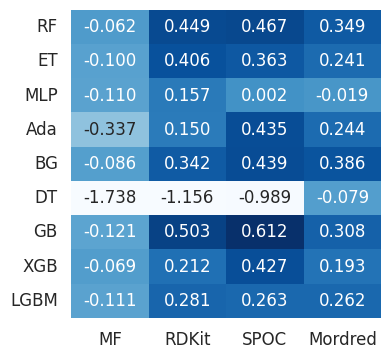

In [9]:
fig = plt.figure(figsize=(4,4))
sns.set(font_scale=1)
sns.heatmap(r2_map.T,annot=True,fmt='.3f',xticklabels=desc_names,yticklabels=model_names,cmap='Blues',cbar=False,vmin=-1,vmax=r2_map.max())

plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
plt.show()
print()

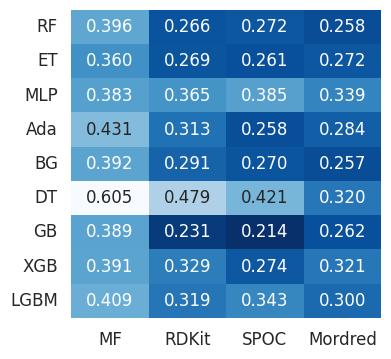

In [10]:
fig = plt.figure(figsize=(4,4))
sns.set(font_scale=1)
sns.heatmap(mae_map.T,annot=True,fmt='.3f',xticklabels=desc_names,yticklabels=model_names,cmap='Blues_r',cbar=False,)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12,rotation=0)
plt.show()
print()

In [11]:
pd.DataFrame(r2_map.T,index=model_names,columns=desc_names).to_csv("../results/model_tsdesc_other_desc_screen_r2.csv")
pd.DataFrame(mae_map.T,index=model_names,columns=desc_names).to_csv("../results/model_tsdesc_other_desc_screen_mae.csv")

## Benchmark of descriptor for ferrocene and ligand

In [13]:
pregen_desc_map = np.load("../desc/desc_for_other_components.npy",allow_pickle=True).item()
other_desc_for_benchmark = np.load("../desc/other_desc_for_benchmark.npy",allow_pickle=True).item()
sel_base_data_clean = pd.read_csv("../data/sel_base_data_clean.csv")
sel_target_data_clean = pd.read_csv("../data/sel_target_data_clean.csv")
sel_base_data_clean = sel_base_data_clean.fillna("")
sel_target_data_clean = sel_target_data_clean.fillna("")
base_rct1_smi = sel_base_data_clean["Reactant1"].tolist()
base_rct2_smi = sel_base_data_clean["Reactant2"].tolist()
base_lig_smi = sel_base_data_clean["Reagent5"].tolist()
base_ddG = sel_base_data_clean["ddG"].to_numpy()

target_rct1_smi = sel_target_data_clean["Reactant1"].tolist()
target_rct2_smi = sel_target_data_clean["Reactant2"].tolist()
target_lig_smi = sel_target_data_clean["Reagent2"].tolist()
target_ddG = sel_target_data_clean["ddG"].to_numpy()

In [ ]:
benmark_desc_lst = ['MorganFingerprints', 'RDKit', 'SPOC', 'Mordred', 'ACSF', 'SOAP', 'MBTR']
desc_for_other_component = pregen_desc_map["SPOC"]
other_desc_for_benchmark[""] = {"MorganFingerprints":np.zeros(2048),"RDKit":np.zeros(210),"SPOC":np.zeros(2258),"Mordred":np.zeros(1613),
                                "ACSF":np.zeros(360),"SOAP":np.zeros(32592),"MBTR":np.zeros(7800)}

target_merg_rxn_desc = desc_for_other_component["target"]
base_merg_rxn_desc = desc_for_other_component["base"]
concat_merge_rxn_desc, concat_merge_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_merg_rxn_desc,base_merg_rxn_desc],axis=0),return_idx=True)                                                               # descriptor process
concat_merge_rxn_desc,concat_merge_rxn_desc_max,concat_merge_rxn_desc_min = maxminscale(concat_merge_rxn_desc,return_scale=True)                                                                                            # descriptor process
concat_merge_rxn_desc,concat_merge_rxn_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_merge_rxn_desc,np.concatenate([target_ddG,base_ddG]),threshold=descriptor_target_pearsonr_threshold,return_idx=True)              # descriptor elimination
concat_merge_rxn_desc,concat_merge_rxn_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_merge_rxn_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)                                                        # descriptor process

target_merg_rxn_desc_ = concat_merge_rxn_desc[:target_merg_rxn_desc.shape[0]]
base_merg_rxn_desc_ = concat_merge_rxn_desc[target_merg_rxn_desc.shape[0]:]
print(f"target_merg_rxn_desc.shape: {target_merg_rxn_desc.shape}, target_merg_rxn_desc_.shape: {target_merg_rxn_desc_.shape}")
print(f"base_merg_rxn_desc.shape: {base_merg_rxn_desc.shape}, base_merg_rxn_desc_.shape: {base_merg_rxn_desc_.shape}")
benchmark_results_map = {}
for desc_name in benmark_desc_lst:
    base_rct1_desc = []
    base_rct2_desc = []
    base_lig_desc = []
    for smi in base_rct1_smi:
        base_rct1_desc.append(other_desc_for_benchmark[smi][desc_name])
    for smi in base_rct2_smi:
        base_rct2_desc.append(other_desc_for_benchmark[smi][desc_name])
    for smi in base_lig_smi:
        base_lig_desc.append(other_desc_for_benchmark[smi][desc_name])
    base_rct1_desc = np.array(base_rct1_desc)
    base_rct2_desc = np.array(base_rct2_desc)
    base_lig_desc = np.array(base_lig_desc)
    base_desc = np.concatenate([base_rct1_desc,base_rct2_desc,base_lig_desc],axis=1)

    target_rct1_desc = []
    target_rct2_desc = []
    target_lig_desc = []
    for smi in target_rct1_smi:
        target_rct1_desc.append(other_desc_for_benchmark[smi][desc_name])
    for smi in target_rct2_smi:
        target_rct2_desc.append(other_desc_for_benchmark[smi][desc_name])
    for smi in target_lig_smi:
        target_lig_desc.append(other_desc_for_benchmark[smi][desc_name])
    target_rct1_desc = np.array(target_rct1_desc)
    target_rct2_desc = np.array(target_rct2_desc)
    target_lig_desc = np.array(target_lig_desc)
    target_desc = np.concatenate([target_rct1_desc,target_rct2_desc,target_lig_desc],axis=1)
    
    concat_bmk_rxn_desc,concat_bmk_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_desc,base_desc],axis=0),return_idx=True)                                                                                  # descriptor process
    concat_bmk_rxn_desc,concat_bmk_rxn_desc_max,concat_bmk_rxn_desc_min = maxminscale(concat_bmk_rxn_desc,return_scale=True)                                                                                                # descriptor process
    concat_bmk_rxn_desc,concat_bmk_rxn_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_bmk_rxn_desc,np.concatenate([target_ddG,base_ddG]),threshold=descriptor_target_pearsonr_threshold,return_idx=True)                # descriptor elimination
    concat_bmk_rxn_desc,concat_bmk_rxn_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_bmk_rxn_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)                                                          # descriptor process
    target_bmk_rxn_desc_ = concat_bmk_rxn_desc[:target_desc.shape[0]]
    base_bmk_rxn_desc_ = concat_bmk_rxn_desc[target_desc.shape[0]:]
    print(f"{desc_name} target_bmk_rxn_desc.shape: {target_desc.shape}, target_bmk_rxn_desc_.shape: {target_bmk_rxn_desc_.shape}")
    print(f"{desc_name} base_bmk_rxn_desc.shape: {base_desc.shape}, base_bmk_rxn_desc_.shape: {base_bmk_rxn_desc_.shape}")
    target_full_bmk_rxn_desc = np.concatenate([target_merg_rxn_desc_,target_bmk_rxn_desc_],axis=1)                       # benchmark descriptor + other component descriptors
    base_full_bmk_rxn_desc = np.concatenate([base_merg_rxn_desc_,base_bmk_rxn_desc_],axis=1)                             # benchmark descriptor + other component descriptors
    
    full_bmk_rxn_desc_std, full_bmk_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_full_bmk_rxn_desc,base_full_bmk_rxn_desc],axis=0),return_idx=True)
    full_bmk_rxn_desc_std, full_bmk_rxn_desc_max, full_bmk_rxn_desc_min = maxminscale(full_bmk_rxn_desc_std,return_scale=True)

    target_bmk_full_rxn_desc_ = full_bmk_rxn_desc_std[:target_full_bmk_rxn_desc.shape[0]]
    base_bmk_full_rxn_desc_ = full_bmk_rxn_desc_std[target_full_bmk_rxn_desc.shape[0]:]
    for model_name in model_lst:
        
        if model_name == "MLPRegressor":
            model = get_model(model_name)
        elif model_name == "DecisionTreeRegressor":
            model = get_model(model_name,model_params={"random_state":random_state})
        else:
            model = get_model(model_name,model_params={"n_estimators":n_estimators,"random_state":random_state})

        va_Y,va_P,score_map = get_val_score_add_data(model,base_bmk_full_rxn_desc_,base_ddG,target_bmk_full_rxn_desc_,target_ddG,selection_inf=selection_inf,merge_method=merge_method,topk=300,dist_type=dist_type)
        benchmark_results_map[(desc_name,model_name)] = {"score_map":score_map,"va_Y":va_Y,"va_P":va_P}
        #print(f"Result: {desc_name} {model_name} {score_map}")
np.save("../results/model_benchmark_desc_screen_results.npy",benchmark_results_map)

target_merg_rxn_desc.shape: (55, 9032), target_merg_rxn_desc_.shape: (55, 193)
base_merg_rxn_desc.shape: (446, 9032), base_merg_rxn_desc_.shape: (446, 193)
MorganFingerprints target_bmk_rxn_desc.shape: (55, 6144), target_bmk_rxn_desc_.shape: (55, 44)
MorganFingerprints base_bmk_rxn_desc.shape: (446, 6144), base_bmk_rxn_desc_.shape: (446, 44)
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based 

In [16]:
benchmark_results_map = np.load("../results/model_benchmark_desc_screen_results.npy",allow_pickle=True).item()
total_desc_model_results = deepcopy(benchmark_results_map)
for key in results_map:
    if "SPOC" in key:
        total_desc_model_results[("TS",key[1])] = results_map[key]

In [17]:
tot_descriptor_lst = sorted(list(set([k[0] for k in total_desc_model_results.keys()])))
tot_model_lst = sorted(list(set([k[1] for k in total_desc_model_results.keys()])))
desc_name_map = {"TS":"TS",'MorganFingerprints':"MF", 'RDKit':"RDKit", 'SPOC':"SPOC", 'Mordred':"Mordred", 'ACSF':"ACSF", 'SOAP':"SOAP", 'MBTR':"MBTR"}
model_name_map = {'RandomForestRegressor':"RF",
                'ExtraTreesRegressor':"ET",
                'MLPRegressor':"MLP",
                'AdaBoostRegressor':"Ada",
                'BaggingRegressor':"BG",
                'DecisionTreeRegressor':"DT",
                'GradientBoostingRegressor':"GB",
                'XGBRegressor':"XGB",
                'LGBMRegressor':"LGBM"}
mae_map = np.zeros((len(tot_descriptor_lst),len(tot_model_lst)))
r2_map = np.zeros((len(tot_descriptor_lst),len(tot_model_lst)))
model_names = [model_name_map[m] for m in tot_model_lst]
desc_names = [desc_name_map[d] for d in tot_descriptor_lst]
for i,m in enumerate(tot_model_lst):
    for j,d in enumerate(tot_descriptor_lst):
        mae_map[j,i] = total_desc_model_results[(d,m)]["score_map"]["mae"]
        r2_map[j,i] = total_desc_model_results[(d,m)]["score_map"]["r2"]

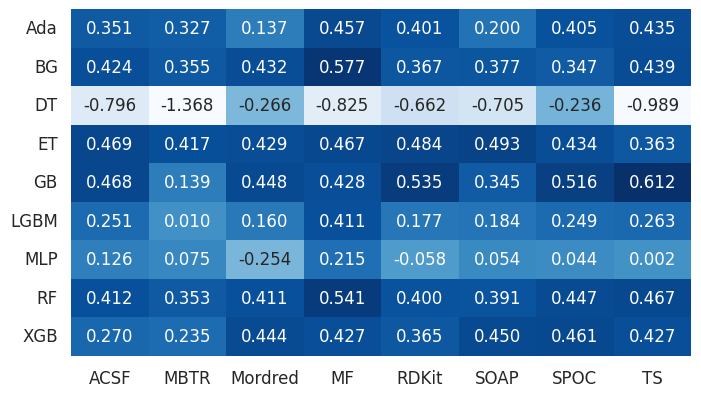

In [18]:
fig = plt.figure(figsize=(8,4.5))

sns.set(font_scale=1)
sns.heatmap(r2_map.T,annot=True,fmt='.3f',xticklabels=desc_names,yticklabels=model_names,cmap='Blues',cbar=False,vmin=-1,vmax=r2_map.max()) # ,vmin=-1,vmax=0.65
plt.xticks(rotation=0,fontsize=12)
plt.yticks(rotation=0,fontsize=12)
plt.show()
print()

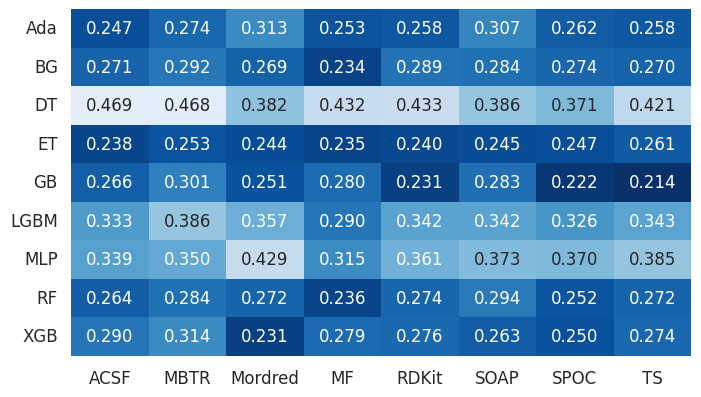

In [19]:
fig = plt.figure(figsize=(8,4.5))

sns.set(font_scale=1)
sns.heatmap(mae_map.T,annot=True,fmt='.3f',xticklabels=desc_names,yticklabels=model_names,cmap='Blues_r',cbar=False,vmin=mae_map.min(),vmax=0.5) # ,vmin=-1,vmax=0.65
plt.xticks(rotation=0,fontsize=12)
plt.yticks(rotation=0,fontsize=12)
plt.show()
print()

In [20]:
pd.DataFrame(r2_map.T,index=model_names,columns=desc_names).to_csv("../results/model_tot_desc_screen_r2.csv")
pd.DataFrame(mae_map.T,index=model_names,columns=desc_names).to_csv("../results/model_tot_desc_screen_mae.csv")